<a href="https://colab.research.google.com/github/JaiswalFelipe/ITNPAI1_Assignment/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INITIAL

In [1]:
import tensorflow as tf
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras import optimizers

# Adjust figure sizes
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 100 

In [2]:
# Load data, Train, val, test split
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

print("Training set size:", X_train.shape)
#print("Validation set size:", X_val.shape)
print("Testing set size:", X_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
Training set size: (45000, 32, 32, 3)
Testing set size: (10000, 32, 32, 3)


# Image samples for each classes

In [3]:
# Creating and populating a dictionary to show random samples of images
class_dict = {"0": [],"1": [],"2": [],"3": [],"4": [],
              "5": [],"6": [],"7": [],"8": [],"9": []}

for i in range(len(X_train)):
  if y_train[i] == 0:
    class_dict["0"].append(X_train[i])
  elif y_train[i] == 1:
    class_dict["1"].append(X_train[i])
  elif y_train[i] == 2:
    class_dict["2"].append(X_train[i])
  elif y_train[i] == 3:
    class_dict["3"].append(X_train[i])
  elif y_train[i] == 4:
    class_dict["4"].append(X_train[i])
  elif y_train[i] == 5:
    class_dict["5"].append(X_train[i]) 
  elif y_train[i] == 6:
    class_dict["6"].append(X_train[i])
  elif y_train[i] == 7:
    class_dict["7"].append(X_train[i])
  elif y_train[i] == 8:
    class_dict["8"].append(X_train[i])
  elif y_train[i] == 9:
    class_dict["9"].append(X_train[i])

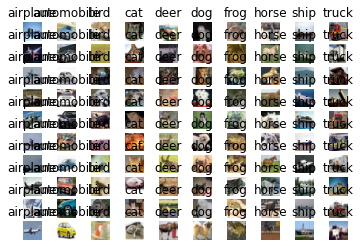

In [4]:
# Create a dict
class_dict_copy = class_dict.copy()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

col = 0

f, axarr = plt.subplots(10,10)

for key in class_dict_copy:
  for i in range(0,10):
    img = random.choice(class_dict_copy[key])
    axarr[col, i].axis("off")
    axarr[col, i].title.set_text(classes[i])
    axarr[i, col].imshow(img)
  col += 1

# Data preparation

In [ ]:
#y_train = np_utils.to_categorical(y_train, num_classes = 10)
#y_test = np_utils.to_categorical(y_test, num_classes = 10)
#y_valid = np_utils.to_categorical(y_valid, num_classes = 10)

In [ ]:
!pip install d2l==0.16.2 # Uncomment and run this if you are using Google Colab

In [6]:
#기존 VGG16에서 parameter 갯수를 줄이고, dense layer 노드 갯수를 줄였습니다.
import pandas as pd
from keras.layers import BatchNormalization
def VGG16_Brief(classes=10): # classes = 감지할 클래스 수
    img_rows, img_cols = 32, 32
    img_channels = 3    
    img_dim = (img_rows, img_cols, img_channels) #차원..shape 정의..
    
    img_input = Input(shape=img_dim) #튜플.. 변경 x

    # Conv1
    x = Conv2D(32,(3,3),padding='same',activation = 'relu')(img_input) #1층
    x = Dropout(0.256)(x)
    #x = Conv2D(32,(3,3),padding='same',activation = 'relu')(x) #2층
    #x = Dropout(0.15)(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x) #2층 maxpool

    # Conv2
    x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) #3층
    x = Dropout(0.25)(x)
    #x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) #4층
    #x = Dropout(0.15)(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x) #4층 maxpool
    #x = Dropout(0.25)(x)

    # Conv3  
    # Output reciever
    x = Conv2D(128,(3,3),padding='same',activation = 'relu')(x) #5층
    x = Dropout(0.25)(x)
    x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) #6층
    #x = Dropout(0.15)(x)
    #x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) #7층
    #x = Dropout(0.15)(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x) #7층 maxpool
    #x = Dropout(0.2)(x)

    # Conv4
    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) #8층
    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) #9층
    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) #10층
    x = MaxPooling2D((2,2),strides=(2,2))(x) #10층 maxpool

    # Conv5
#    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) #11층
#    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) #12층
#    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) #13층
#    x = MaxPooling2D((2,2),strides=(2,2))(x) #13층 maxpool

    # FC
    x = Flatten()(x)
    x = Dense(1024, activation = 'relu')(x) #14층   # Dense(1024
    x = Dropout(0.5)(x)
    #x = Dense(4096, activation = 'relu')(x) #15층
    x = Dense(512, activation = 'relu')(x) #15층
    x = Dropout(0.5)(x)
    x = Dense(classes, activation = 'softmax')(x)
    
    model = Model(inputs=img_input, outputs = x)
    return model

model_ep25 = VGG16_Brief(classes = 10)
model_ep25.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                             

### Epoch 25

In [ ]:
model_ep25.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#loss를 categorical_crossentropy 대신 sparse_categorical_crossentropy 사용

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.00001)


history_ep25 = model_ep25.fit(X_train, y_train, epochs=25,
        validation_data=(X_valid, y_valid),callbacks = [learning_rate_reduction],batch_size=256)

Epoch 1/25
176/176 [==============================] - 23s 125ms/step - loss: 0.4280 - accuracy: 0.8616 - val_loss: 0.8041 - val_accuracy: 0.7454 - lr: 0.0010
Epoch 2/25
176/176 [==============================] - 22s 123ms/step - loss: 0.4032 - accuracy: 0.8703 - val_loss: 0.7711 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 3/25
176/176 [==============================] - 22s 124ms/step - loss: 0.3876 - accuracy: 0.8744 - val_loss: 0.7937 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 4/25
176/176 [==============================] - 22s 124ms/step - loss: 0.3660 - accuracy: 0.8832 - val_loss: 0.7991 - val_accuracy: 0.7490 - lr: 0.0010
Epoch 5/25
176/176 [==============================] - 22s 124ms/step - loss: 0.3738 - accuracy: 0.8804 - val_loss: 0.7993 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 6/25
176/176 [==============================] - 22s 123ms/step - loss: 0.3799 - accuracy: 0.8776 - val_loss: 0.8516 - val_accuracy: 0.7328 - lr: 0.0010
Epoch 7/25
176/176 [==============================] 

In [8]:
test_loss, test_acc = model_ep25.evaluate(X_test,y_test)
print('test loss:', test_loss)
print('test acc:', test_acc)

313/313 [==============================] - 5s 15ms/step - loss: 1.0980 - accuracy: 0.7730
test loss: 1.0980384349822998
test acc: 0.7730000019073486


In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_ep25.history["accuracy"], 'y', label= 'ACCURACY')
plt.plot(history_ep25.history["val_accuracy"], 'g', label= 'VAL_ACC')

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.show()

In [ ]:
plt.subplot(111)
plt.plot(history_ep25.history['loss'], 'r', label= 'LOSS')
plt.plot(history_ep25.history["val_loss"], 'b', label= 'VAL_LOSS')
#plt.plot(test_acc, 'r', label= 'TEST_ACC')
plt.ylabel("LOSS")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.show()

### Epoch 50

### Epoch 75

### SAVE MODEL


# Another model

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.datasets import cifar10
from keras import backend as K
from matplotlib import pyplot
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from keras.models import model_from_json

In [ ]:
#model = Sequential()
#model.add(Conv2D(32,(3,3), input_shape = (32, 32, 3), padding = 'same', activation = 'relu'))
#model.add(Dropout(0.2))
#model.add(Conv2D(32,(3,3), padding = 'same', activation = 'relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Conv2D(64,(3,3), padding = 'same', activation = 'relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dropout(0.2))
#model.add(Dense(512,activation='relu',kernel_constraint=maxnorm(3)))
#model.add(Dropout(0.2))
#model.add(Dense(num_classes, activation='softmax'))

#epochs = 25
#lrate = 0.01
#decay = lrate/epochs
#sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
#model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
#epochs = 25
#lrate = 0.01
#decay = lrate/epochs
#sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
#model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=32)

Epoch 1/25
1407/1407 [==============================] - 30s 14ms/step - loss: nan - accuracy: 0.1005 - val_loss: nan - val_accuracy: 0.0958
Epoch 2/25
1407/1407 [==============================] - 18s 12ms/step - loss: nan - accuracy: 0.1005 - val_loss: nan - val_accuracy: 0.0958
Epoch 3/25
1407/1407 [==============================] - 18s 13ms/step - loss: nan - accuracy: 0.1005 - val_loss: nan - val_accuracy: 0.0958
Epoch 4/25
1407/1407 [==============================] - 18s 13ms/step - loss: nan - accuracy: 0.1005 - val_loss: nan - val_accuracy: 0.0958
Epoch 5/25
1407/1407 [==============================] - 18s 12ms/step - loss: nan - accuracy: 0.1005 - val_loss: nan - val_accuracy: 0.0958
Epoch 6/25
1407/1407 [==============================] - 18s 12ms/step - loss: nan - accuracy: 0.1005 - val_loss: nan - val_accuracy: 0.0958
Epoch 7/25
1407/1407 [==============================] - 18s 13ms/step - loss: nan - accuracy: 0.1005 - val_loss: nan - val_accuracy: 0.0958
Epoch 8/25
1407/1407

In [ ]:
#scores = model.evaluate(X_test,y_test,verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 10.00%


# Hyperparameter tuning
# data augmentation?  